## Check GPU

In [7]:
!nvidia-smi

Wed Mar 29 19:03:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.65       Driver Version: 527.56       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   57C    P8    15W / 115W |    313MiB /  8192MiB |     36%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Importing necessary Library

In [1]:
import numpy as np
import os
import pickle
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LambdaCallback,EarlyStopping
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import random
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout 
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications import ResNet50V2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

2023-03-29 19:03:44.404357: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-29 19:03:44.641985: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/gwan/micromamba/envs/cs109b/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Getting sense of data

In [2]:
labels_dict = {0:'no', 1:'sphere', 2:'vort'}
folder_path = 'dataset/dataset/train/'
filepaths = []
label_values = []
for label, value in labels_dict.items():
    class_folder = os.path.join(folder_path, value + '/')
    for file in os.listdir(class_folder):
        if file.endswith('.npy'):
            filepaths.append(os.path.join(class_folder, file))
            label_values.append(label)
image = np.load(filepaths[0])
image.shape

(1, 150, 150)

In [3]:
image

array([[[0.01488834, 0.00992556, 0.00992556, ..., 0.00992556,
         0.00124069, 0.00372208],
        [0.01861042, 0.00992556, 0.00744417, ..., 0.00868486,
         0.01488834, 0.00496278],
        [0.00620347, 0.00868486, 0.00744417, ..., 0.01736973,
         0.00992556, 0.00744417],
        ...,
        [0.00620347, 0.01116625, 0.00496278, ..., 0.00992556,
         0.01116625, 0.00992556],
        [0.01116625, 0.00744417, 0.00992556, ..., 0.01488834,
         0.01488834, 0.00868486],
        [0.01240695, 0.01364764, 0.01488834, ..., 0.00744417,
         0.00992556, 0.01861042]]])

In [4]:
label_values[-5]

2

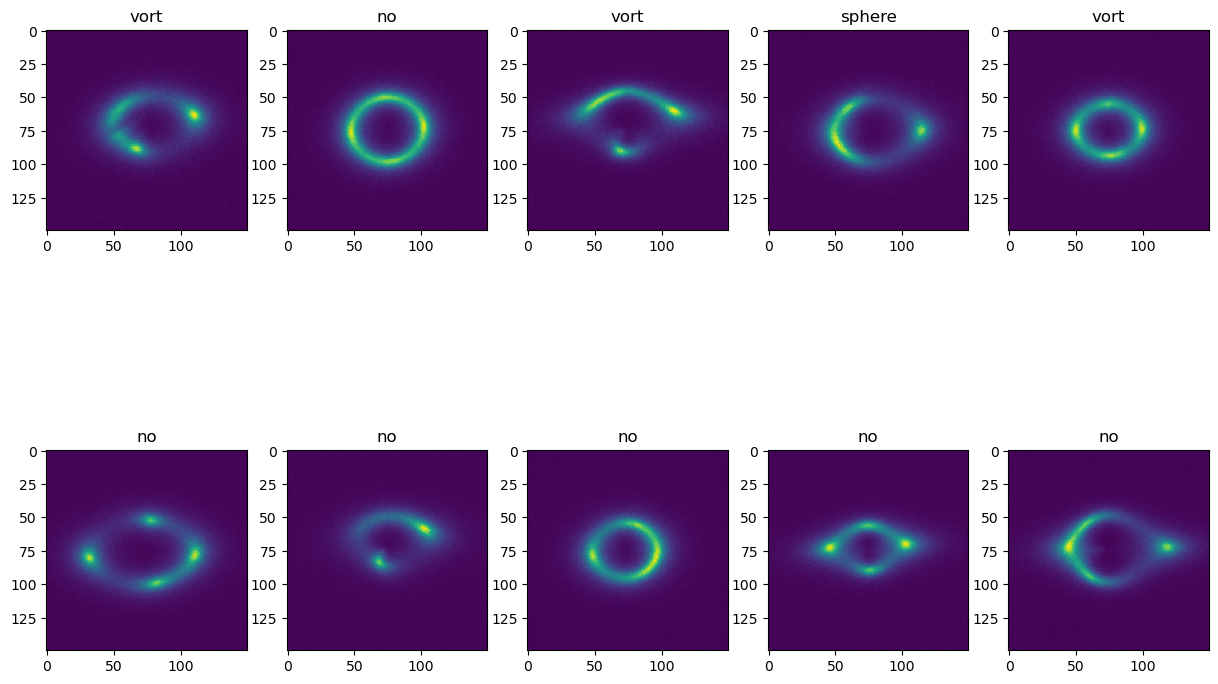

In [5]:
def plot_images(filepaths, labels, x, num_cols):
    num_rows = int(np.ceil(x / num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

    for i in range(x):
        # Randomly select an image from the filepaths list
        idx = np.random.randint(len(filepaths))
        filepath, label = filepaths[idx], labels[idx]
        
        # Load the image from the .npy file
        image = np.load(filepath)
        image = image.transpose(1, 2, 0)
        # Plot the image with its label as the title
        # Calculate the row and column index for this image
        row_idx = i // num_cols
        col_idx = i % num_cols
        
        # Plot the image with its label as the title
        axes[row_idx, col_idx].imshow(image)
        axes[row_idx, col_idx].set_title(labels_dict[labels[idx]])
    # Remove any unused subplot axes
    for i in range(x, num_rows*num_cols):
        row_idx = i // num_cols
        col_idx = i % num_cols
        axes[row_idx, col_idx].axis('off')        
    plt.show()
plot_images(filepaths, label_values, x=10, num_cols=5)

# Define HyperParameters

In [6]:
batch_size = 16
es_callback = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
callbacks = [es_callback]
train_path = 'dataset/dataset/train/'
test_path = 'dataset/dataset/val/'
epochs = 100

## Data Preprocessing

In [8]:
def get_filepaths_and_labels(folder_path):
    labels_dict = {0:'no', 1:'sphere', 2:'vort'}
    filepaths = []
    label_values = []
    for label, value in labels_dict.items():
        class_folder = os.path.join(folder_path, value + '/')
        for file in os.listdir(class_folder):
            if file.endswith('.npy'):
                filepaths.append(os.path.join(class_folder, file))
                label_values.append(label)
    random.seed(109)
    random.shuffle(filepaths)
    random.seed(109)
    random.shuffle(label_values)
    return filepaths, label_values
x_all, labels_all = get_filepaths_and_labels(train_path)
test_filepaths, test_labels = get_filepaths_and_labels(test_path)
train_filepaths, val_filepaths, train_labels, val_labels = train_test_split(x_all, labels_all, test_size=0.1, random_state=42)


train_files_ds = tf.data.Dataset.from_tensor_slices((train_filepaths,train_labels))
val_files_ds = tf.data.Dataset.from_tensor_slices((val_filepaths,val_labels))
test_files_ds = tf.data.Dataset.from_tensor_slices((test_filepaths, test_labels ))


def load_and_preprocess(file_path, label):
    data = np.load(file_path.numpy())
    data = data.transpose(1, 2, 0)
    data = np.repeat(data, 3, axis=-1)  # Convert the single channel to three channels
    return data.astype(np.float32), tf.one_hot(label, depth=3)

def load_and_preprocess_wrapper(file_path, label):
    return tf.py_function(load_and_preprocess, [file_path, label], [tf.float32, tf.float32])

def augment(image, label):

    # Apply random rotation
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Apply random brightness
    image = tf.image.random_brightness(image, max_delta=0.05)

    # Apply random contrast
    image = tf.image.random_contrast(image, lower=0.95, upper=1.05)

    return image, label

# Apply augmentation to train_ds

train_ds = train_files_ds.map(load_and_preprocess_wrapper, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_files_ds.map(load_and_preprocess_wrapper, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_files_ds.map(load_and_preprocess_wrapper, num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_ds = train_ds.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)


# Print the number of examples in each set
print("Number of examples in the training set:", len(train_ds))
print("Number of examples in the validation set:", len(val_ds))
print("Number of examples in the test set:", len(test_ds))

2023-03-29 19:04:04.716170: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-29 19:04:04.901491: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-29 19:04:04.901933: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-29 19:04:04.903915: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FM

Number of examples in the training set: 27000
Number of examples in the validation set: 3000
Number of examples in the test set: 7500


In [13]:
def count_labels(data):
    label_counts = {}

    # Iterate through the dataset and count the occurrences of each label
    for x,y in data:
        label = labels_dict[int(tf.argmax(np.array(y)))]
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

    # Print the label distribution
    for label, count in label_counts.items():
        print(f"Label {label} : {count} samples")
print("Label distribution (val):")
count_labels(val_ds)

Label distribution (val):
Label vort : 1023 samples
Label sphere : 1039 samples
Label no : 938 samples


In [ ]:
print("Label distribution (test):")
count_labels(test_ds)

## Simple CNN experiments

In [21]:
model_cnn = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

# Compile model
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(),
                       tf.keras.metrics.AUC(curve='ROC', multi_label=True)])

# Train model using generator

history_cnn = model_cnn.fit(
        train_ds.batch(batch_size).prefetch(buffer_size = tf.data.experimental.AUTOTUNE),
        epochs=epochs,
        shuffle=True,
        callbacks = callbacks,
        validation_data=val_ds.batch(batch_size).prefetch(buffer_size = tf.data.experimental.AUTOTUNE),
    )

Epoch 1/5
844/844 [==============================] - 89s 100ms/step - loss: 5.9536 - categorical_accuracy: 0.3327 - auc_3: 0.4977 - val_loss: 1.1809 - val_categorical_accuracy: 0.3410 - val_auc_3: 0.4999
Epoch 2/5
844/844 [==============================] - 84s 99ms/step - loss: 1.1430 - categorical_accuracy: 0.3356 - auc_3: 0.4997 - val_loss: 1.1329 - val_categorical_accuracy: 0.3410 - val_auc_3: 0.5000
Epoch 3/5
844/844 [==============================] - 81s 97ms/step - loss: 1.1362 - categorical_accuracy: 0.3351 - auc_3: 0.4987 - val_loss: 1.1297 - val_categorical_accuracy: 0.3413 - val_auc_3: 0.5004
Epoch 4/5
844/844 [==============================] - 85s 100ms/step - loss: 1.1395 - categorical_accuracy: 0.3351 - auc_3: 0.4995 - val_loss: 1.1331 - val_categorical_accuracy: 0.3410 - val_auc_3: 0.5004
Epoch 5/5
844/844 [==============================] - 81s 96ms/step - loss: 1.1499 - categorical_accuracy: 0.3347 - auc_3: 0.5006 - val_loss: 1.1325 - val_categorical_accuracy: 0.3410 - v

In [24]:
# Save the model
model_cnn.save('model_cnn.h5')

# Save the history
with open('history_cnn.pkl', 'wb') as file:
    pickle.dump(history_cnn.history, file)

# More complex model(transfer learning)

In [9]:
def Transfer_Learning_training(base_model):
    base_model.trainable = False
    # We make sure that the base_model is running in inference mode here,
    # by passing `training=False`. This is important for fine-tuning, as you will
    # Add a global average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)  # Regularize with dropout
    # A Dense classifier with a single unit (binary classification)
    outputs = Dense(3, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(),
                       tf.keras.metrics.AUC(curve='ROC', multi_label=True)])

    # Train the model with the new layers for a few epochs
    initial_epochs = int(epochs * 0.2)
    history = model.fit(train_ds.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE),
                        epochs=initial_epochs,
                        shuffle = True,
                        callbacks=callbacks,
                        validation_data = val_ds.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE))
    base_model.trainable = True
# Compile the model with a lower learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.CategoricalAccuracy(),
                           tf.keras.metrics.AUC(curve='ROC', multi_label=True)])
    # Fine-tune the model for a few more epochs
    total_epochs = epochs

    history_fine = model.fit(train_ds.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE),
                             initial_epoch=initial_epochs,
                             epochs=total_epochs,
                             shuffle = True,
                             callbacks=callbacks,
                             validation_data = val_ds.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE))
    return model,[history,history_fine]

## 1st Model (Fine Tuned Xception)

In [18]:
# Load the Xception model without the top layers
base_model_1 = Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
model_xce,history_xce = Transfer_Learning_training(base_model_1)

83683744/83683744 [==============================] - 9s 0us/step
Epoch 1/4
844/844 [==============================] - 91s 103ms/step - loss: 1.0706 - categorical_accuracy: 0.4059 - auc_2: 0.5945 - val_loss: 1.0373 - val_categorical_accuracy: 0.4230 - val_auc_2: 0.6525
Epoch 2/4
844/844 [==============================] - 94s 111ms/step - loss: 1.0371 - categorical_accuracy: 0.4369 - auc_2: 0.6300 - val_loss: 1.0159 - val_categorical_accuracy: 0.4543 - val_auc_2: 0.6616
Epoch 3/4
844/844 [==============================] - 98s 117ms/step - loss: 1.0310 - categorical_accuracy: 0.4431 - auc_2: 0.6365 - val_loss: 1.0122 - val_categorical_accuracy: 0.4490 - val_auc_2: 0.6660
Epoch 4/4
844/844 [==============================] - 97s 115ms/step - loss: 1.0200 - categorical_accuracy: 0.4511 - auc_2: 0.6467 - val_loss: 1.0170 - val_categorical_accuracy: 0.4603 - val_auc_2: 0.6549
Epoch 5/20


2023-03-29 06:00:24.853452: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.92GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-29 06:00:25.362181: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.50GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-29 06:00:25.776387: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-29 06:00:33.399255: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

622/844 [=====================>........] - ETA: 1:20 - loss: 1.1122 - categorical_accuracy: 0.3749 - auc_3: 0.5542

KeyboardInterrupt: 

In [20]:
model

NameError: name 'model' is not defined

In [ ]:
# Save the model
model_xce.save('model_xce.h5')

# Save the history
with open('history_xce.pkl', 'wb') as file:
    pickle.dump(history_xce.history, file)

# 2nd Model, DenseNet121 

In [16]:
base_model_2 = DenseNet121(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
model_den,history_den = Transfer_Learning_training(base_model_2)

29084464/29084464 [==============================] - 3s 0us/step
Epoch 1/4


2023-03-29 05:46:24.942606: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-03-29 05:46:34.594826: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-29 05:46:37.850803: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-29 05:46:37.960910: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f9d65728e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-29 05:46:37.961060: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2023-03-29 05:46:38.078960: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-29 05:

844/844 [==============================] - 112s 105ms/step - loss: 1.1107 - categorical_accuracy: 0.3658 - auc: 0.5381 - val_loss: 1.0698 - val_categorical_accuracy: 0.4140 - val_auc: 0.5966
Epoch 2/4
844/844 [==============================] - 85s 101ms/step - loss: 1.0662 - categorical_accuracy: 0.4101 - auc: 0.5847 - val_loss: 1.0422 - val_categorical_accuracy: 0.4347 - val_auc: 0.6342
Epoch 3/4
844/844 [==============================] - 89s 106ms/step - loss: 1.0559 - categorical_accuracy: 0.4153 - auc: 0.5927 - val_loss: 1.0255 - val_categorical_accuracy: 0.4490 - val_auc: 0.6442
Epoch 4/4
844/844 [==============================] - 97s 115ms/step - loss: 1.0455 - categorical_accuracy: 0.4290 - auc: 0.6068 - val_loss: 1.0229 - val_categorical_accuracy: 0.4447 - val_auc: 0.6493


NameError: name 'epoches' is not defined

In [ ]:
# Save the model
model_den.save('model_den.h5')

# Save the history
with open('history_den.pkl', 'wb') as file:
    pickle.dump(history_den.history, file)

Epoch 1/20
469/469 [==============================] - 149s 307ms/step - loss: 1.1047 - categorical_accuracy: 0.3680 - auc_9: 0.5426 - val_loss: 1.0819 - val_categorical_accuracy: 0.4003 - val_auc_9: 0.5900
Epoch 2/20
469/469 [==============================] - 142s 302ms/step - loss: 1.0768 - categorical_accuracy: 0.3965 - auc_9: 0.5819 - val_loss: 1.0664 - val_categorical_accuracy: 0.4236 - val_auc_9: 0.6123
Epoch 3/20
469/469 [==============================] - 127s 271ms/step - loss: 1.0671 - categorical_accuracy: 0.4059 - auc_9: 0.5972 - val_loss: 1.0538 - val_categorical_accuracy: 0.4317 - val_auc_9: 0.6226
Epoch 4/20
469/469 [==============================] - 129s 274ms/step - loss: 1.0592 - categorical_accuracy: 0.4146 - auc_9: 0.6089 - val_loss: 1.0453 - val_categorical_accuracy: 0.4348 - val_auc_9: 0.6294
Epoch 5/20
469/469 [==============================] - 125s 267ms/step - loss: 1.0527 - categorical_accuracy: 0.4200 - auc_9: 0.6159 - val_loss: 1.0403 - val_categorical_accurac

# 3rd Model Mobile Net

In [10]:
base_model_3 = ResNet50V2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
model_res,history_res = Transfer_Learning_training(base_model_3)

94668760/94668760 [==============================] - 11s 0us/step
Epoch 1/20


2023-03-29 19:04:52.854785: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-03-29 19:04:56.286620: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-29 19:04:57.580043: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-29 19:04:57.608660: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fb3f16c8b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-29 19:04:57.608709: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2023-03-29 19:04:57.650414: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-29 19:

844/844 [==============================] - 90s 95ms/step - loss: 1.0949 - categorical_accuracy: 0.3780 - auc: 0.5541 - val_loss: 1.0543 - val_categorical_accuracy: 0.4240 - val_auc: 0.6150
Epoch 2/20
 57/844 [=>............................] - ETA: 1:04 - loss: 1.0623 - categorical_accuracy: 0.4057 - auc: 0.5898

In [ ]:
# Save the model
model_mbn.save('model_mbn.h5')

# Save the history
with open('history_mbn.pkl', 'wb') as file:
    pickle.dump(history_mbn.history, file)

# Load the Model 

# Visulize Results

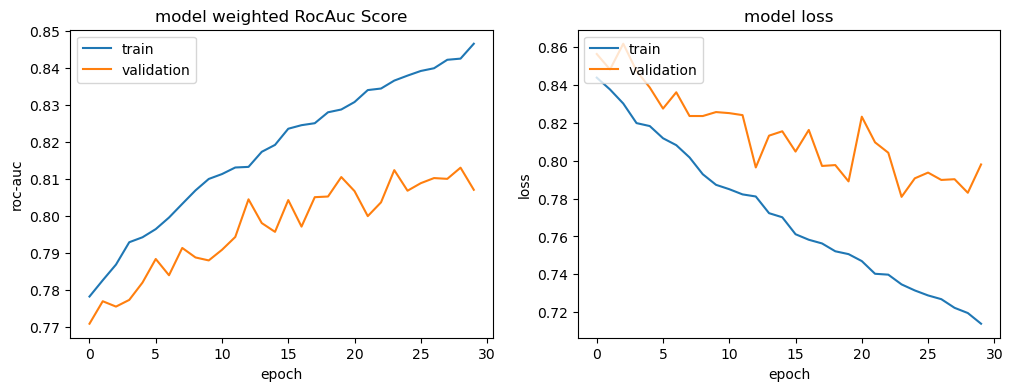

In [13]:
def plot_loss(model_history, out_file = None):
    """
    This helper function plots the NN model accuracy and loss.
    Arguments:
        model_history: the model history return from fit()
        out_file: the (optional) path to save the image file to.
    """
    fig, ax = plt.subplots(1, 2, figsize = (12, 4))
    
    history = model_history
    
    ax[0].plot(history.history['auc_2'])
    ax[0].plot(history.history['val_auc_2'])
    ax[0].set_title('model weighted RocAuc Score')
    ax[0].set_ylabel('roc-auc')
    ax[0].set_xlabel('epoch')
    ax[0].legend(['train', 'validation'], loc='upper left')
    
    # summarize history for loss
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('model loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    if out_file:
        plt.savefig(out_file)

plot_loss(model_history = history_den[1]);

In [10]:
# pred_train = model.predict(train_ds.batch(batch_size))
# pred = model.predict(val_ds.batch(batch_size))
# pred_train.mean(axis = 0)

118/118 [==============================] - 29s 244ms/step


array([0.33198193, 0.312826  , 0.35518995], dtype=float32)

In [11]:
# pred

array([[6.8024033e-01, 1.2982869e-01, 1.8993098e-01],
       [5.3962920e-04, 8.9137375e-01, 1.0808665e-01],
       [3.2319775e-01, 4.6328413e-01, 2.1351805e-01],
       ...,
       [3.2144509e-02, 7.0033348e-01, 2.6752198e-01],
       [3.7873054e-01, 3.0244991e-01, 3.1881952e-01],
       [9.8031646e-01, 1.1518905e-02, 8.1646768e-03]], dtype=float32)